In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D 
import seaborn as sns
from scipy.ndimage import gaussian_filter1d
import pickle as pkl
import mne

In [2]:
behav_df = pd.read_csv('C:/Users/qmoreau/Documents/Work/Beta_bursts/Behavioral/behav_df_cleaned_new.csv')
burst_df = pd.read_csv('C:/Users/qmoreau/Documents/Work/Beta_bursts/Bursts/burst_features.csv')

In [3]:
lookup_df = behav_df[["coh_cat", "perturb_cat", "trial", "block", "subject", "reach_vis_abs_err"]]

# Merge the two DataFrames based on the specified columns and fill missing values with NaN
df_burst_behav = burst_df.merge(lookup_df, on=["trial", "block", "subject"], how='left')

In [4]:
group_implicit_subjects = behav_df[behav_df['group'] == "Implicit"]['subject'].unique()
group_explicit_subjects = behav_df[behav_df['group'] == "Explicit"]['subject'].unique()

In [5]:
import numpy as np
import pandas as pd
from scipy.ndimage import gaussian_filter1d

def calculate_PC_rates(behav_df, df_burst_behav, PC_to_analyse, group, time_bin=0.05, time_buffer=0.125):
    """
    Calculate burst rates for all quartiles of a given PC for a given group and time range.
    Uses visual epochs to compute the baseline but only processes motor epochs.

    Parameters:
    - behav_df: DataFrame containing behavioral data
    - df_burst_behav: DataFrame containing burst behavioral data
    - PC_to_analyse: Principal component (PC) to analyze
    - group: The group for which burst rates are calculated
    - time_bin: Time bin for burst rate calculation
    - time_buffer: Time buffer for extending the time range

    Returns:
    - mot_time_range: Time range for motor bursts
    - PC_dict: Dictionary containing burst rates for each subject, block, and quartile combination
    """

    # Select subjects based on the group
    group_subjects = behav_df[behav_df['group'] == group]['subject'].unique()

    # Define time ranges
    vis_time_range = np.arange(-1 - time_buffer, 2 + time_buffer, time_bin)  # Visual epoch time range
    mot_time_range = np.arange(-1 - time_buffer, 1.5 + time_buffer, time_bin)  # Motor epoch time range

    # Define the baseline range using visual epochs
    baseline_range = [-0.5, -0.25]

    # Extract visual bursts for baseline correction only
    vis_burst_df = df_burst_behav[df_burst_behav['epoch'] == 'vis']
    
    # Extract motor burst data for processing
    mot_burst_df = df_burst_behav[df_burst_behav['epoch'] == 'mot']

    # Create a dictionary to store burst rates for each subject, block, and quartile combination
    PC_dict = {}

    for subject in group_subjects:
        # Extract motor and visual data for the subject
        mot_subject_df = mot_burst_df[mot_burst_df['subject'] == subject]
        vis_subject_df = vis_burst_df[vis_burst_df['subject'] == subject]  # Needed for baseline calculation

        new_column = f"{PC_to_analyse}_quartile"

        # Filter for each quartile of PC and calculate burst rates
        for quartile in range(4):
            # Motor data quartile
            mot_subject_df_quartile = mot_subject_df[mot_subject_df[PC_to_analyse].notnull()]
            mot_subject_df_quartile[new_column] = pd.qcut(mot_subject_df_quartile[PC_to_analyse], 
                                                           q=[0, 0.25, 0.5, 0.75, 1.0], labels=False)
            mot_subject_df_quartile = mot_subject_df_quartile[mot_subject_df_quartile[new_column] == quartile]

            # Visual data quartile for baseline calculation
            vis_subject_df_quartile = vis_subject_df[vis_subject_df[PC_to_analyse].notnull()]
            vis_subject_df_quartile[new_column] = pd.qcut(vis_subject_df_quartile[PC_to_analyse], 
                                                           q=[0, 0.25, 0.5, 0.75, 1.0], labels=False)
            vis_subject_df_quartile = vis_subject_df_quartile[vis_subject_df_quartile[new_column] == quartile]

            # Initialize arrays for burst rates
            mot_subject_PC_rate = np.zeros((len(mot_time_range),))
            vis_subject_PC_rate = np.zeros((len(vis_time_range),))

            # Group by block
            mot_grouped_df = mot_subject_df_quartile.groupby(['block'])
            vis_grouped_df = vis_subject_df_quartile.groupby(['block'])

            for (block, mot_group) in mot_grouped_df:
                # Compute motor burst rates
                for i, t in enumerate(mot_time_range):
                    mot_subject_PC_rate[i] = len(mot_group[(mot_group['peak_time'] >= t) & 
                                                           (mot_group['peak_time'] < t + time_bin)]) / time_bin

                mot_subject_PC_rate_smoothed = gaussian_filter1d(mot_subject_PC_rate, sigma=1)

                # Compute visual burst rates for baseline (if available)
                if block in vis_grouped_df.groups:
                    vis_group = vis_grouped_df.get_group(block)
                    for i, t in enumerate(vis_time_range):
                        vis_subject_PC_rate[i] = len(vis_group[(vis_group['peak_time'] >= t) & 
                                                                (vis_group['peak_time'] < t + time_bin)]) / time_bin

                    vis_subject_PC_rate_smoothed = gaussian_filter1d(vis_subject_PC_rate, sigma=1)

                    # Baseline correction from visual epoch
                    baseline_mask = (vis_time_range >= baseline_range[0]) & (vis_time_range < baseline_range[1])
                    baseline = np.mean(vis_subject_PC_rate_smoothed[baseline_mask])
                

                # Apply baseline correction to motor burst rates
                mot_subject_PC_rate_smoothed = ((mot_subject_PC_rate_smoothed - baseline) / baseline) * 100

                # Store the burst rates in the dictionary
                key = (block, quartile)
                if key not in PC_dict:
                    PC_dict[key] = []

                PC_dict[key].append(mot_subject_PC_rate_smoothed)

    for key in PC_dict:
        PC_dict[key] = [x for x in PC_dict[key]]
    
    return mot_time_range, PC_dict


In [6]:
selected_PCs = ['PC_7', 'PC_8', 'PC_9', 'PC_10']
for pc in selected_PCs:
    # Compute burst rates for Explicit and Implicit groups
    mot_time_range, explicit_data = calculate_PC_rates(behav_df, df_burst_behav, pc, "Explicit")
    mot_time_range, implicit_data = calculate_PC_rates(behav_df, df_burst_behav, pc, "Implicit")

    # Dynamically assign variables
    globals()[f"group_explicit_{pc}"] = explicit_data
    globals()[f"group_implicit_{pc}"] = implicit_data


C:\Users\qmoreau\AppData\Local\Temp\ipykernel_28336\3316191187.py:71: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for (block, mot_group) in mot_grouped_df:
C:\Users\qmoreau\AppData\Local\Temp\ipykernel_28336\3316191187.py:71: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for (block, mot_group) in mot_grouped_df:
C:\Users\qmoreau\AppData\Local\Temp\ipykernel_28336\3316191187.py:71: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for (block, mot_group) in mot_grouped_df:
C

In [7]:
def group_and_append(data_list, block_list):
    mot_burst_rates_dict = {}

    for i, group in enumerate(data_list):
        for quartile in range(4):
            mot_key = f"group_{i}_mot_burst_rates_Q{quartile}"
            mot_burst_rates_list = []

            for block in block_list:
                key = (block, quartile)
                mot_burst_rates = group.get(key, [])
                mot_burst_rates_list.append(mot_burst_rates)

            mot_burst_rates_dict[mot_key] = np.mean(mot_burst_rates_list, axis=0)

    return mot_burst_rates_dict


In [8]:
block_list = [1,2,3,4,5,6]

mot_burst_rates_dict_PC_7 = group_and_append([group_explicit_PC_7, group_implicit_PC_7], block_list)
mot_burst_rates_dict_PC_8 = group_and_append([group_explicit_PC_8, group_implicit_PC_8], block_list)
mot_burst_rates_dict_PC_9 = group_and_append([group_explicit_PC_9, group_implicit_PC_9], block_list)
mot_burst_rates_dict_PC_10 = group_and_append([group_explicit_PC_10, group_implicit_PC_10], block_list)

In [9]:
block_list_baseline = [0]

mot_burst_rates_dict_PC_7_baseline = group_and_append([group_explicit_PC_7, group_implicit_PC_7], block_list_baseline)

block_list_washout = [7]
mot_burst_rates_dict_PC_7_washout = group_and_append([group_explicit_PC_7, group_implicit_PC_7], block_list_washout)

In [10]:
colors0 = sns.color_palette("magma", n_colors=6)
colors1 = sns.color_palette("mako_r", n_colors=10)
pastel = sns.color_palette("Pastel1", n_colors=6)
adapt1 = sns.color_palette("Set1", n_colors=9)
adapt2 = sns.color_palette("Accent", n_colors=8)
colors4 = sns.color_palette("magma_r", n_colors=4)
colors5 = sns.color_palette("mako_r", n_colors=4)

colorbl = [adapt1[4], colors1[2]]

Using a threshold of 4.121338
stat_fun(H1): min=0.000000 max=0.962568
Running initial clustering …
Found 0 clusters
No significant clusters found for PC_7 - Quartile 0.
Using a threshold of 4.121338
stat_fun(H1): min=0.000081 max=1.042928
Running initial clustering …
Found 0 clusters
No significant clusters found for PC_7 - Quartile 1.
Using a threshold of 4.121338
stat_fun(H1): min=0.012450 max=2.632625
Running initial clustering …
Found 0 clusters
No significant clusters found for PC_7 - Quartile 2.
Using a threshold of 4.121338
stat_fun(H1): min=0.062364 max=8.617168
Running initial clustering …
Found 2 clusters


C:\Users\qmoreau\AppData\Local\Temp\ipykernel_28336\158194294.py:67: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  t_obs, clusters, p_values, _ = permutation_cluster_test(
C:\Users\qmoreau\AppData\Local\Temp\ipykernel_28336\158194294.py:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  t_obs, clusters, p_values, _ = permutation_cluster_test(
C:\Users\qmoreau\AppData\Local\Temp\ipykernel_28336\158194294.py:67: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  t_obs, clusters, p_values, _ = permutation_cluster_test(
C:\Users\qmoreau\AppData\Local\Temp\ipykernel_28336\158194294.py:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  t_obs, clusters, p_values, _ = permutation_cluster_test(
C:\Users\qmoreau\AppData\Local\Temp\ipykernel_28336\158194294.py:67: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  t_obs, clusters, p_values, _ = permutation_cluster

  0%|          | Permuting : 0/9999 [00:00<?,       ?it/s]

Minimum FDR-corrected p-value for PC_7 - Quartile 3: 0.0616
Using a threshold of 4.121338
stat_fun(H1): min=0.000138 max=0.989032
Running initial clustering …
Found 0 clusters
No significant clusters found for PC_8 - Quartile 0.
Using a threshold of 4.121338
stat_fun(H1): min=0.001639 max=1.687546
Running initial clustering …
Found 0 clusters
No significant clusters found for PC_8 - Quartile 1.
Using a threshold of 4.121338
stat_fun(H1): min=0.004611 max=2.645001
Running initial clustering …
Found 0 clusters
No significant clusters found for PC_8 - Quartile 2.
Using a threshold of 4.121338
stat_fun(H1): min=0.019083 max=8.306024
Running initial clustering …
Found 2 clusters


C:\Users\qmoreau\AppData\Local\Temp\ipykernel_28336\158194294.py:67: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  t_obs, clusters, p_values, _ = permutation_cluster_test(
C:\Users\qmoreau\AppData\Local\Temp\ipykernel_28336\158194294.py:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  t_obs, clusters, p_values, _ = permutation_cluster_test(
C:\Users\qmoreau\AppData\Local\Temp\ipykernel_28336\158194294.py:67: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  t_obs, clusters, p_values, _ = permutation_cluster_test(
C:\Users\qmoreau\AppData\Local\Temp\ipykernel_28336\158194294.py:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  t_obs, clusters, p_values, _ = permutation_cluster_test(
C:\Users\qmoreau\AppData\Local\Temp\ipykernel_28336\158194294.py:67: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  t_obs, clusters, p_values, _ = permutation_cluster

  0%|          | Permuting : 0/9999 [00:00<?,       ?it/s]

Minimum FDR-corrected p-value for PC_8 - Quartile 3: 0.094
Using a threshold of 4.121338
stat_fun(H1): min=0.000039 max=4.177030
Running initial clustering …
Found 1 cluster


C:\Users\qmoreau\AppData\Local\Temp\ipykernel_28336\158194294.py:67: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  t_obs, clusters, p_values, _ = permutation_cluster_test(


  0%|          | Permuting : 0/9999 [00:00<?,       ?it/s]

Minimum FDR-corrected p-value for PC_9 - Quartile 0: 0.2896
Using a threshold of 4.121338
stat_fun(H1): min=0.000507 max=1.148632
Running initial clustering …
Found 0 clusters
No significant clusters found for PC_9 - Quartile 1.
Using a threshold of 4.121338
stat_fun(H1): min=0.000008 max=3.833720
Running initial clustering …
Found 0 clusters
No significant clusters found for PC_9 - Quartile 2.
Using a threshold of 4.121338
stat_fun(H1): min=0.078236 max=7.230309
Running initial clustering …
Found 1 cluster


C:\Users\qmoreau\AppData\Local\Temp\ipykernel_28336\158194294.py:67: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  t_obs, clusters, p_values, _ = permutation_cluster_test(
C:\Users\qmoreau\AppData\Local\Temp\ipykernel_28336\158194294.py:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  t_obs, clusters, p_values, _ = permutation_cluster_test(
C:\Users\qmoreau\AppData\Local\Temp\ipykernel_28336\158194294.py:67: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  t_obs, clusters, p_values, _ = permutation_cluster_test(
C:\Users\qmoreau\AppData\Local\Temp\ipykernel_28336\158194294.py:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  t_obs, clusters, p_values, _ = permutation_cluster_test(
C:\Users\qmoreau\AppData\Local\Temp\ipykernel_28336\158194294.py:67: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  t_obs, clusters, p_values, _ = permutation_cluster

  0%|          | Permuting : 0/9999 [00:00<?,       ?it/s]

Minimum FDR-corrected p-value for PC_9 - Quartile 3: 0.0884
Using a threshold of 4.121338
stat_fun(H1): min=0.001740 max=4.927379
Running initial clustering …
Found 2 clusters


C:\Users\qmoreau\AppData\Local\Temp\ipykernel_28336\158194294.py:67: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  t_obs, clusters, p_values, _ = permutation_cluster_test(


  0%|          | Permuting : 0/9999 [00:00<?,       ?it/s]

Minimum FDR-corrected p-value for PC_10 - Quartile 0: 0.1692
Using a threshold of 4.121338
stat_fun(H1): min=0.000748 max=1.192497
Running initial clustering …
Found 0 clusters
No significant clusters found for PC_10 - Quartile 1.
Using a threshold of 4.121338
stat_fun(H1): min=0.001078 max=2.013404
Running initial clustering …
Found 0 clusters
No significant clusters found for PC_10 - Quartile 2.
Using a threshold of 4.121338
stat_fun(H1): min=0.008433 max=3.984538
Running initial clustering …
Found 0 clusters
No significant clusters found for PC_10 - Quartile 3.


C:\Users\qmoreau\AppData\Local\Temp\ipykernel_28336\158194294.py:67: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  t_obs, clusters, p_values, _ = permutation_cluster_test(
C:\Users\qmoreau\AppData\Local\Temp\ipykernel_28336\158194294.py:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  t_obs, clusters, p_values, _ = permutation_cluster_test(
C:\Users\qmoreau\AppData\Local\Temp\ipykernel_28336\158194294.py:67: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  t_obs, clusters, p_values, _ = permutation_cluster_test(
C:\Users\qmoreau\AppData\Local\Temp\ipykernel_28336\158194294.py:67: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  t_obs, clusters, p_values, _ = permutation_cluster_test(
C:\Users\qmoreau\AppData\Local\Temp\ipykernel_28336\158194294.py:67: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  t_obs, clusters, p_values, _ = permutation_cluster

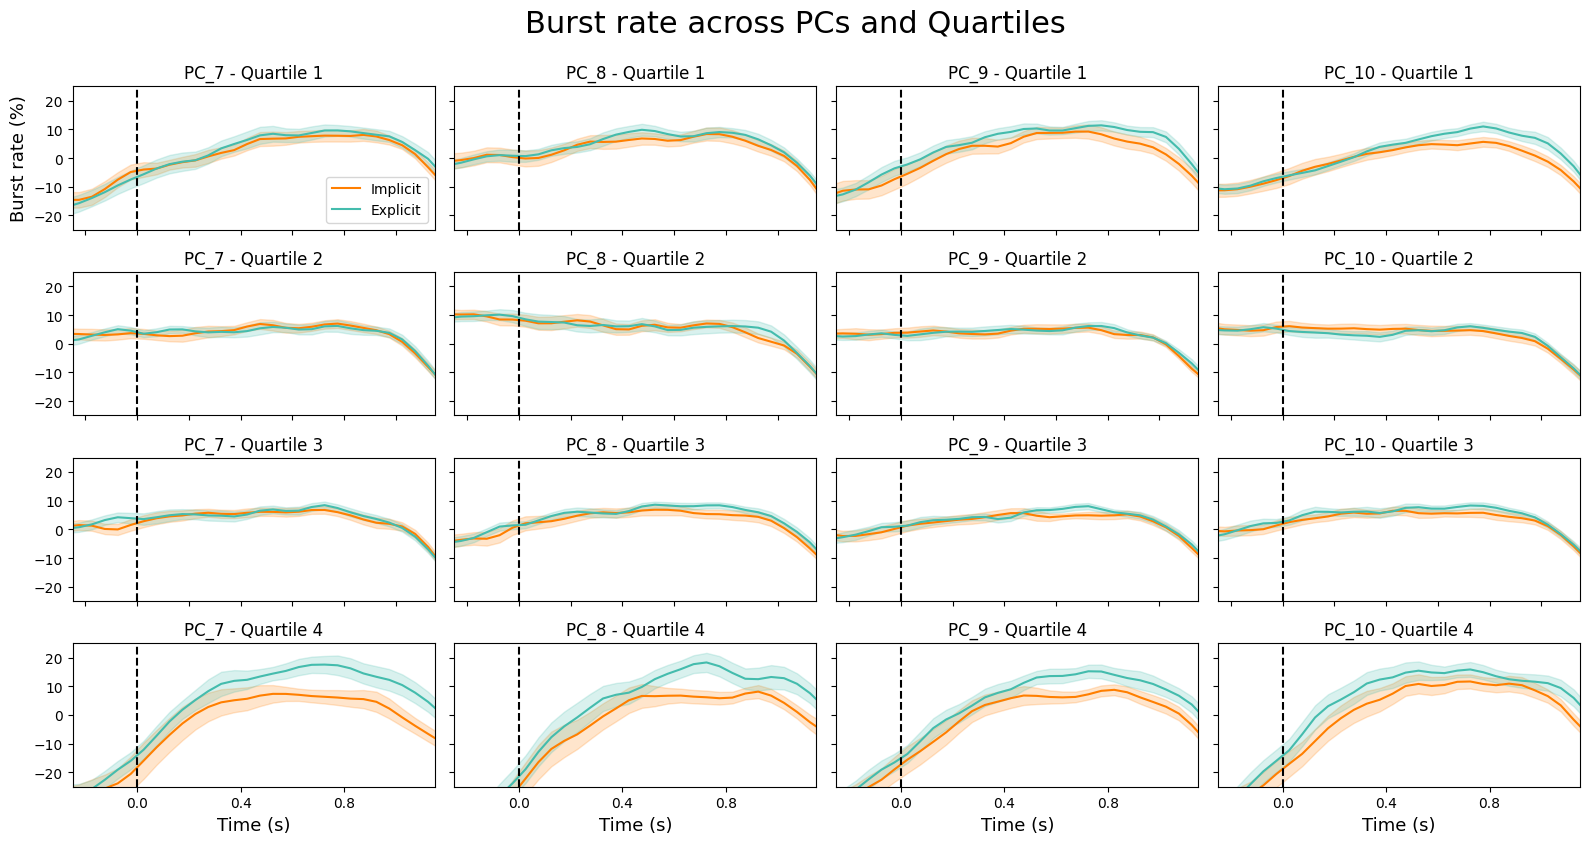

In [11]:
import matplotlib.pyplot as plt
from mne.stats import permutation_cluster_test, fdr_correction  # Assuming you are using MNE for permutation_cluster_test and fdr_correction
import numpy as np

# Assuming you have defined mot_time_range, mot_burst_rates_dict_PC_7, mot_burst_rates_dict_PC_8, mot_burst_rates_dict_PC_9, and mot_burst_rates_dict_PC_10 before

# Set the common time range
plot_time_range = [-0.25, 1.15]

# Create a figure with 4 subplots for each quartile and 4 blocks
fig, axs = plt.subplots(4, 4, figsize=(16, 8), sharey=True)

block_labels = ['PC_7', 'PC_8', 'PC_9', 'PC_10']
burst_rates_dicts = [mot_burst_rates_dict_PC_7, mot_burst_rates_dict_PC_8, mot_burst_rates_dict_PC_9, mot_burst_rates_dict_PC_10]

# Loop through each block
for j, (burst_rates_dict, block_label) in enumerate(zip(burst_rates_dicts, block_labels)):
    # Loop through each quartile
    for i in range(4):
        # Get quartile keys
        mot_key_group_0 = f"group_0_mot_burst_rates_Q{i}"
        mot_key_group_1 = f"group_1_mot_burst_rates_Q{i}"

        # Plot for Implicit (group 0)
        line0, = axs[i, j].plot(mot_time_range, burst_rates_dict[mot_key_group_0].mean(axis=0), label='Implicit', color=colorbl[0])
        axs[i, j].fill_between(mot_time_range,
                               burst_rates_dict[mot_key_group_0].mean(axis=0) - burst_rates_dict[mot_key_group_0].std(axis=0) / np.sqrt(len(burst_rates_dict[mot_key_group_0])),
                               burst_rates_dict[mot_key_group_0].mean(axis=0) + burst_rates_dict[mot_key_group_0].std(axis=0) / np.sqrt(len(burst_rates_dict[mot_key_group_0])), alpha=0.2, color=colorbl[0])

        # Plot for Explicit (group 1)
        line1, = axs[i, j].plot(mot_time_range, burst_rates_dict[mot_key_group_1].mean(axis=0), label='Explicit', color=colorbl[1])
        axs[i, j].fill_between(mot_time_range,
                               burst_rates_dict[mot_key_group_1].mean(axis=0) - burst_rates_dict[mot_key_group_1].std(axis=0) / np.sqrt(len(burst_rates_dict[mot_key_group_1])),
                               burst_rates_dict[mot_key_group_1].mean(axis=0) + burst_rates_dict[mot_key_group_1].std(axis=0) / np.sqrt(len(burst_rates_dict[mot_key_group_1])), alpha=0.2, color=colorbl[1])

        # Set x axis limits
        axs[i, j].set_xlim(plot_time_range)

        # Add a line at time 0
        axs[i, j].axvline(x=0, color='black', linestyle='--')

        # # Only set y-label for the first column and show y-tick values
        if i == 0 and j == 0:
            axs[i, j].set_ylabel('Burst rate (%)', fontsize=13)

        # Only set x-label for the last row
        if i == 3:
            axs[i, j].set_xlabel('Time (s)', fontsize=13)
            # Set fewer ticks on x-axis
            axs[i, j].xaxis.set_major_locator(plt.MaxNLocator(4))
        else:
            axs[i, j].set_xticklabels([])

        # Only add legend to the first subplot
        if i == 0 and j == 0:
            axs[i, j].legend()
        else:
            axs[i, j].legend().set_visible(False)

        axs[i, j].set_title(f'{block_label} - Quartile {i+1}')
        axs[i, j].set_ylim(-25, 25)  # Set the y-axis limits

        selected_time_indices = (mot_time_range >= plot_time_range[0]) & (mot_time_range <= plot_time_range[1])
        selected_time_points = mot_time_range[selected_time_indices]

        # Run permutation_cluster_test
        t_obs, clusters, p_values, _ = permutation_cluster_test(
            [burst_rates_dict[mot_key_group_0][:, selected_time_indices], burst_rates_dict[mot_key_group_1][:, selected_time_indices]],
            n_permutations=10000, n_jobs=1)

        # Check if p_values is not empty
        if p_values.size > 0:
            # Apply FDR correction
            # _, p_values_fdr = fdr_correction(p_values, alpha=0.05, method='indep')
            p_values_fdr = p_values

            # Print the minimum FDR-corrected p-value
            print(f'Minimum FDR-corrected p-value for {block_label} - Quartile {i}:', p_values_fdr.min())
            concatenated_sig_mask = np.zeros(len(selected_time_points), dtype=bool)

            # Add significant clusters to the plot
            for cluster, p_val in zip(clusters, p_values_fdr):
                if p_val < 0.05:
                    cluster_indices = cluster[0]
                    concatenated_sig_mask[cluster_indices] = True
                    axs[i, j].scatter(selected_time_points[concatenated_sig_mask], 
                                      [12] * sum(concatenated_sig_mask), 
                                      color='red', s=25)
        else:
            print(f'No significant clusters found for {block_label} - Quartile {i}.')


# Adjust layout to prevent overlap
plt.tight_layout()
plt.suptitle('Burst rate across PCs and Quartiles', fontsize=22, y=1.05)
# Show the plots
plt.show()


In [12]:
selected_PCs = ['PC_7', 'PC_8', 'PC_9', 'PC_10']
coh_cats = ['zero', 'low', 'med', 'high']

for pc in selected_PCs:
    for coh in coh_cats:
        # Filter data for the specific coherence category
        df_burst_behav_coh = df_burst_behav[df_burst_behav['coh_cat'] == coh]

        # Compute burst rates for Explicit and Implicit groups
        mot_time_range, explicit_data = calculate_PC_rates(behav_df, df_burst_behav_coh, pc, "Explicit")
        mot_time_range, implicit_data = calculate_PC_rates(behav_df, df_burst_behav_coh, pc, "Implicit")

        # Dynamically assign variables
        globals()[f"group_explicit_{pc}_{coh}"] = explicit_data
        globals()[f"group_implicit_{pc}_{coh}"] = implicit_data


C:\Users\qmoreau\AppData\Local\Temp\ipykernel_28336\3316191187.py:71: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for (block, mot_group) in mot_grouped_df:
C:\Users\qmoreau\AppData\Local\Temp\ipykernel_28336\3316191187.py:71: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for (block, mot_group) in mot_grouped_df:
C:\Users\qmoreau\AppData\Local\Temp\ipykernel_28336\3316191187.py:71: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for (block, mot_group) in mot_grouped_df:
C

Using a threshold of 2.624636
stat_fun(H1): min=0.115780 max=3.540506
Running initial clustering …
Found 3 clusters


C:\Users\qmoreau\AppData\Local\Temp\ipykernel_28336\4186258553.py:70: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  t_obs, clusters, p_values, _ = permutation_cluster_test(


  0%|          | Permuting : 0/9999 [00:00<?,       ?it/s]

Minimum p-value for PC_7 - Q1: 0.0675
Using a threshold of 2.624636
stat_fun(H1): min=0.000152 max=2.519016
Running initial clustering …
Found 0 clusters
No significant clusters found for PC_7 - Q2.
Using a threshold of 2.624636
stat_fun(H1): min=0.005730 max=3.008644
Running initial clustering …
Found 1 cluster


C:\Users\qmoreau\AppData\Local\Temp\ipykernel_28336\4186258553.py:70: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  t_obs, clusters, p_values, _ = permutation_cluster_test(
C:\Users\qmoreau\AppData\Local\Temp\ipykernel_28336\4186258553.py:70: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  t_obs, clusters, p_values, _ = permutation_cluster_test(
C:\Users\qmoreau\AppData\Local\Temp\ipykernel_28336\4186258553.py:70: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  t_obs, clusters, p_values, _ = permutation_cluster_test(


  0%|          | Permuting : 0/9999 [00:00<?,       ?it/s]

Minimum p-value for PC_7 - Q3: 0.3375
Using a threshold of 2.624636
stat_fun(H1): min=0.391626 max=3.549425
Running initial clustering …
Found 3 clusters


C:\Users\qmoreau\AppData\Local\Temp\ipykernel_28336\4186258553.py:70: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  t_obs, clusters, p_values, _ = permutation_cluster_test(


  0%|          | Permuting : 0/9999 [00:00<?,       ?it/s]

Minimum p-value for PC_7 - Q4: 0.126
Using a threshold of 2.624636
stat_fun(H1): min=0.012556 max=4.360436
Running initial clustering …
Found 1 cluster


C:\Users\qmoreau\AppData\Local\Temp\ipykernel_28336\4186258553.py:70: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  t_obs, clusters, p_values, _ = permutation_cluster_test(


  0%|          | Permuting : 0/9999 [00:00<?,       ?it/s]

Minimum p-value for PC_8 - Q1: 0.0892
Using a threshold of 2.624636
stat_fun(H1): min=0.074739 max=2.553151
Running initial clustering …
Found 0 clusters
No significant clusters found for PC_8 - Q2.
Using a threshold of 2.624636
stat_fun(H1): min=0.140253 max=4.992677
Running initial clustering …
Found 2 clusters


C:\Users\qmoreau\AppData\Local\Temp\ipykernel_28336\4186258553.py:70: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  t_obs, clusters, p_values, _ = permutation_cluster_test(
C:\Users\qmoreau\AppData\Local\Temp\ipykernel_28336\4186258553.py:70: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  t_obs, clusters, p_values, _ = permutation_cluster_test(
C:\Users\qmoreau\AppData\Local\Temp\ipykernel_28336\4186258553.py:70: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  t_obs, clusters, p_values, _ = permutation_cluster_test(


  0%|          | Permuting : 0/9999 [00:00<?,       ?it/s]

Minimum p-value for PC_8 - Q3: 0.0604
Using a threshold of 2.624636
stat_fun(H1): min=0.528366 max=5.749598
Running initial clustering …
Found 4 clusters


C:\Users\qmoreau\AppData\Local\Temp\ipykernel_28336\4186258553.py:70: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  t_obs, clusters, p_values, _ = permutation_cluster_test(


  0%|          | Permuting : 0/9999 [00:00<?,       ?it/s]

Minimum p-value for PC_8 - Q4: 0.0561
Using a threshold of 2.624636
stat_fun(H1): min=0.042995 max=2.635741
Running initial clustering …
Found 1 cluster


C:\Users\qmoreau\AppData\Local\Temp\ipykernel_28336\4186258553.py:70: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  t_obs, clusters, p_values, _ = permutation_cluster_test(


  0%|          | Permuting : 0/9999 [00:00<?,       ?it/s]

Minimum p-value for PC_9 - Q1: 0.4509
Using a threshold of 2.624636
stat_fun(H1): min=0.007117 max=2.313570
Running initial clustering …
Found 0 clusters
No significant clusters found for PC_9 - Q2.
Using a threshold of 2.624636
stat_fun(H1): min=0.326298 max=4.188634
Running initial clustering …
Found 2 clusters


C:\Users\qmoreau\AppData\Local\Temp\ipykernel_28336\4186258553.py:70: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  t_obs, clusters, p_values, _ = permutation_cluster_test(
C:\Users\qmoreau\AppData\Local\Temp\ipykernel_28336\4186258553.py:70: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  t_obs, clusters, p_values, _ = permutation_cluster_test(
C:\Users\qmoreau\AppData\Local\Temp\ipykernel_28336\4186258553.py:70: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  t_obs, clusters, p_values, _ = permutation_cluster_test(


  0%|          | Permuting : 0/9999 [00:00<?,       ?it/s]

Minimum p-value for PC_9 - Q3: 0.0652
Using a threshold of 2.624636
stat_fun(H1): min=0.201699 max=4.046892
Running initial clustering …
Found 2 clusters


C:\Users\qmoreau\AppData\Local\Temp\ipykernel_28336\4186258553.py:70: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  t_obs, clusters, p_values, _ = permutation_cluster_test(


  0%|          | Permuting : 0/9999 [00:00<?,       ?it/s]

Minimum p-value for PC_9 - Q4: 0.086
Using a threshold of 2.624636
stat_fun(H1): min=0.123926 max=2.893557
Running initial clustering …
Found 1 cluster


C:\Users\qmoreau\AppData\Local\Temp\ipykernel_28336\4186258553.py:70: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  t_obs, clusters, p_values, _ = permutation_cluster_test(


  0%|          | Permuting : 0/9999 [00:00<?,       ?it/s]

Minimum p-value for PC_10 - Q1: 0.3338
Using a threshold of 2.624636
stat_fun(H1): min=0.241109 max=2.130998
Running initial clustering …
Found 0 clusters
No significant clusters found for PC_10 - Q2.
Using a threshold of 2.624636
stat_fun(H1): min=0.085542 max=2.126496
Running initial clustering …
Found 0 clusters
No significant clusters found for PC_10 - Q3.
Using a threshold of 2.624636


C:\Users\qmoreau\AppData\Local\Temp\ipykernel_28336\4186258553.py:70: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  t_obs, clusters, p_values, _ = permutation_cluster_test(
C:\Users\qmoreau\AppData\Local\Temp\ipykernel_28336\4186258553.py:70: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  t_obs, clusters, p_values, _ = permutation_cluster_test(
C:\Users\qmoreau\AppData\Local\Temp\ipykernel_28336\4186258553.py:70: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  t_obs, clusters, p_values, _ = permutation_cluster_test(
C:\Users\qmoreau\AppData\Local\Temp\ipykernel_28336\4186258553.py:70: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  t_obs, clusters, p_values, _ = permutation_cluster_test(
C:\Users\qmoreau\AppData\Local\Temp\ipykernel_28336\4186258553.py:70: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  t_obs, clusters, p_values, _ = permutation_cl

stat_fun(H1): min=0.233651 max=4.044605
Running initial clustering …
Found 1 cluster


  0%|          | Permuting : 0/9999 [00:00<?,       ?it/s]

Minimum p-value for PC_10 - Q4: 0.0333


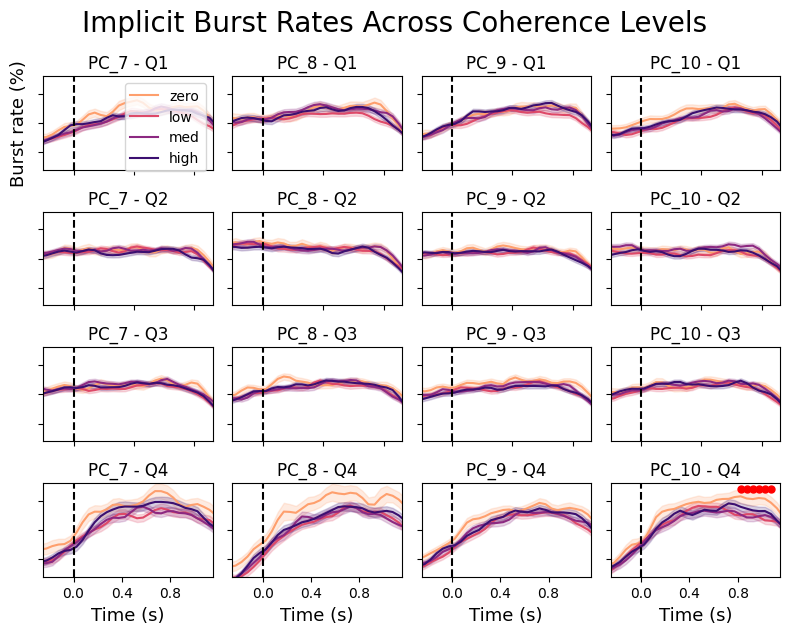

In [17]:

# Define colors for coherence categories
colors4 = sns.color_palette("magma_r", n_colors=4)

coh_colors = {
    "zero": colors4[0],
    "low": colors4[1],
    "med": colors4[2],
    "high": colors4[3]
}

# Define time range
plot_time_range = [-0.25, 1.15]

# Define PCs and coherence categories
selected_PCs = ['PC_7', 'PC_8', 'PC_9', 'PC_10']
coh_cats = ['zero', 'low', 'med', 'high']

# Create figure (4 rows = quartiles, 4 columns = PCs)
fig, axs = plt.subplots(4, 4, figsize=(8, 6), sharey=True)

for j, pc in enumerate(selected_PCs):  # Loop through PCs
    implicit_data_all_coh = {
        coh: globals().get(f"group_implicit_{pc}_{coh}", {}) for coh in coh_cats
    }

    for i in range(4):  # Loop through quartiles
        ax = axs[i, j]

        # Extract quartile data for each coherence level
        coh_burst_rates = {}
        for coh in coh_cats:
            keys = [(blk, i) for blk in range(1, 7)]  # Aggregate across blocks
            if any(k in implicit_data_all_coh[coh] for k in keys):
                coh_burst_rates[coh] = np.vstack(
                    [implicit_data_all_coh[coh][k] for k in keys if k in implicit_data_all_coh[coh]]
                )

        # Ensure we have data for all coherence categories
        if len(coh_burst_rates) == 4:
            # Compute mean & SEM for each coherence level
            coh_means = {coh: coh_burst_rates[coh].mean(axis=0) for coh in coh_cats}
            coh_sems = {coh: coh_burst_rates[coh].std(axis=0) / np.sqrt(coh_burst_rates[coh].shape[0]) for coh in coh_cats}

            # Plot coherence data
            for coh in coh_cats:
                ax.plot(mot_time_range, coh_means[coh], label=coh, color=coh_colors[coh])
                ax.fill_between(mot_time_range, coh_means[coh] - coh_sems[coh], coh_means[coh] + coh_sems[coh], alpha=0.2, color=coh_colors[coh])

            # Set axis limits and labels
            ax.set_xlim(plot_time_range)
            ax.axvline(x=0, color='black', linestyle='--')

            if j == 0 and i == 0:
                ax.set_ylabel('Burst rate (%)', fontsize=13)
            else:
                ax.set_yticklabels([])
            if i == 3:
                ax.set_xlabel('Time (s)', fontsize=13)
                ax.xaxis.set_major_locator(plt.MaxNLocator(4))
            else:
                ax.set_xticklabels([])

            ax.set_title(f'{pc} - Q{i+1}')
            ax.set_ylim(-40, 40)

            # Statistical testing: Compare coherence categories within quartiles
            selected_time_indices = (mot_time_range >= plot_time_range[0]) & (mot_time_range <= plot_time_range[1])
            selected_time_points = mot_time_range[selected_time_indices]

            t_obs, clusters, p_values, _ = permutation_cluster_test(
                [coh_burst_rates[coh][:, selected_time_indices] for coh in coh_cats],
                n_permutations=10000, n_jobs=1
            )

            # If significant clusters exist
            if p_values.size > 0:
                print(f'Minimum p-value for {pc} - Q{i+1}:', p_values.min())
                concatenated_sig_mask = np.zeros(len(selected_time_points), dtype=bool)

                for cluster, p_val in zip(clusters, p_values):
                    if p_val < 0.05:
                        cluster_indices = cluster[0]
                        concatenated_sig_mask[cluster_indices] = True
                        ax.scatter(selected_time_points[concatenated_sig_mask], 
                                   [35] * sum(concatenated_sig_mask), 
                                   color='red', s=25)
            else:
                print(f'No significant clusters found for {pc} - Q{i+1}.')

        # Only add legend to the first subplot
        if i == 0 and j == 0:
            ax.legend()
        else:
            ax.legend().set_visible(False)

# Adjust layout and display the plots
plt.tight_layout()
plt.suptitle('Implicit Burst Rates Across Coherence Levels', fontsize=20, y=1.05)
plt.show()

Using a threshold of 4.121338
stat_fun(H1): min=0.000000 max=0.962568
Running initial clustering …
Found 0 clusters
No significant clusters found for PC_7 - Quartile 0.
Using a threshold of 4.121338
stat_fun(H1): min=0.000081 max=1.542436
Running initial clustering …
Found 0 clusters
No significant clusters found for PC_7 - Quartile 1.
Using a threshold of 4.121338
stat_fun(H1): min=0.012450 max=2.632625
Running initial clustering …
Found 0 clusters
No significant clusters found for PC_7 - Quartile 2.
Using a threshold of 4.121338
stat_fun(H1): min=0.000003 max=8.617168
Running initial clustering …
Found 2 clusters


C:\Users\qmoreau\AppData\Local\Temp\ipykernel_28336\13768858.py:51: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  t_obs, clusters, p_values, _ = permutation_cluster_test(
C:\Users\qmoreau\AppData\Local\Temp\ipykernel_28336\13768858.py:51: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  t_obs, clusters, p_values, _ = permutation_cluster_test(
C:\Users\qmoreau\AppData\Local\Temp\ipykernel_28336\13768858.py:51: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  t_obs, clusters, p_values, _ = permutation_cluster_test(
C:\Users\qmoreau\AppData\Local\Temp\ipykernel_28336\13768858.py:51: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  t_obs, clusters, p_values, _ = permutation_cluster_test(
C:\Users\qmoreau\AppData\Local\Temp\ipykernel_28336\13768858.py:51: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  t_obs, clusters, p_values, _ = permutation_cluster_test

  0%|          | Permuting : 0/9999 [00:00<?,       ?it/s]

Minimum p-value for PC_7 - Quartile 3: 0.0775


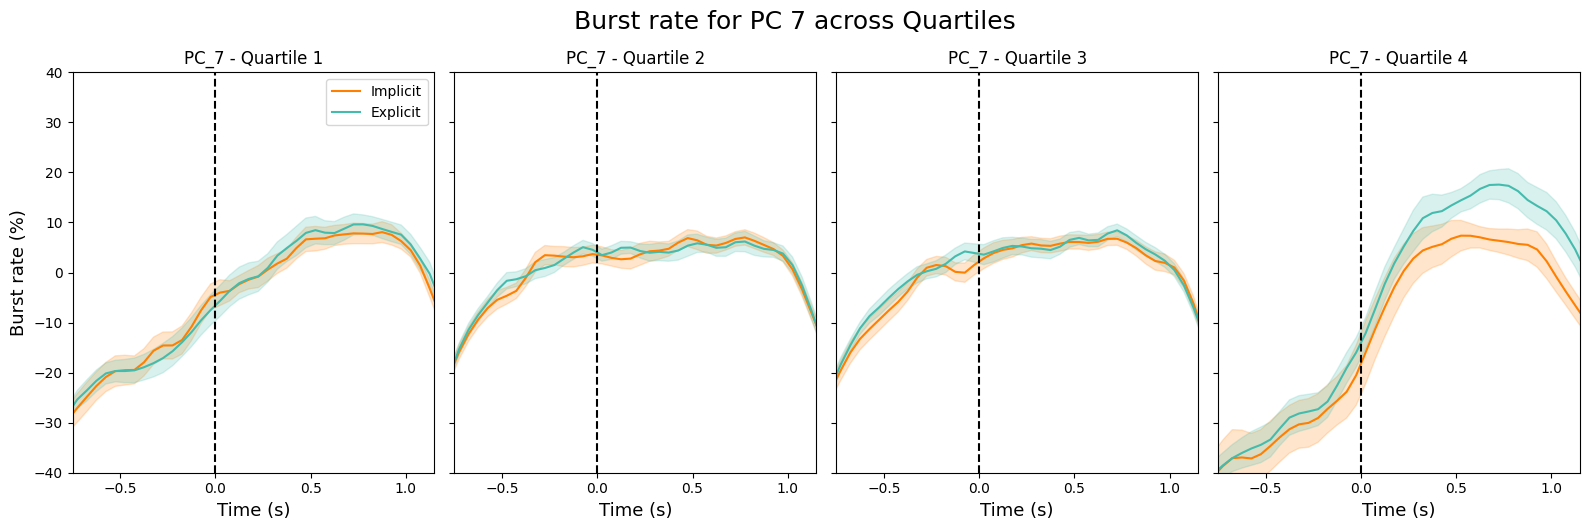

In [18]:

# Set the common time range
plot_time_range = [-0.75, 1.15]

# Create a figure with 4 subplots for each quartile
fig, axs = plt.subplots(1, 4, figsize=(16, 5), sharey=True)

# Loop through each quartile
for i in range(4):
    # Get quartile keys
    mot_key_group_0 = f"group_0_mot_burst_rates_Q{i}"
    mot_key_group_1 = f"group_1_mot_burst_rates_Q{i}"

    # Plot for Implicit (group 0)
    line0, = axs[i].plot(mot_time_range, mot_burst_rates_dict_PC_7[mot_key_group_0].mean(axis=0), label='Implicit', color=colorbl[0])
    axs[i].fill_between(mot_time_range,
                        mot_burst_rates_dict_PC_7[mot_key_group_0].mean(axis=0) - mot_burst_rates_dict_PC_7[mot_key_group_0].std(axis=0) / np.sqrt(len(mot_burst_rates_dict_PC_7[mot_key_group_0])),
                        mot_burst_rates_dict_PC_7[mot_key_group_0].mean(axis=0) + mot_burst_rates_dict_PC_7[mot_key_group_0].std(axis=0) / np.sqrt(len(mot_burst_rates_dict_PC_7[mot_key_group_0])), 
                        alpha=0.2, color=colorbl[0])

    # Plot for Explicit (group 1)
    line1, = axs[i].plot(mot_time_range, mot_burst_rates_dict_PC_7[mot_key_group_1].mean(axis=0), label='Explicit', color=colorbl[1])
    axs[i].fill_between(mot_time_range,
                        mot_burst_rates_dict_PC_7[mot_key_group_1].mean(axis=0) - mot_burst_rates_dict_PC_7[mot_key_group_1].std(axis=0) / np.sqrt(len(mot_burst_rates_dict_PC_7[mot_key_group_1])),
                        mot_burst_rates_dict_PC_7[mot_key_group_1].mean(axis=0) + mot_burst_rates_dict_PC_7[mot_key_group_1].std(axis=0) / np.sqrt(len(mot_burst_rates_dict_PC_7[mot_key_group_1])), 
                        alpha=0.2, color=colorbl[1])

    # Set x axis limits
    axs[i].set_xlim(plot_time_range)

    # Add a line at time 0
    axs[i].axvline(x=0, color='black', linestyle='--')

    # Set y-label for the first subplot
    if i == 0:
        axs[i].set_ylabel('Burst rate (%)', fontsize=13)
        axs[i].legend()


    axs[i].set_xlabel('Time (s)', fontsize=13)
    axs[i].xaxis.set_major_locator(plt.MaxNLocator(4))


    axs[i].set_title(f'PC_7 - Quartile {i+1}')
    axs[i].set_ylim(-40, 40)  # Set the y-axis limits

    # Select time indices within range
    selected_time_indices = (mot_time_range >= plot_time_range[0]) & (mot_time_range <= plot_time_range[1])
    selected_time_points = mot_time_range[selected_time_indices]

    # Run permutation_cluster_test
    t_obs, clusters, p_values, _ = permutation_cluster_test(
        [mot_burst_rates_dict_PC_7[mot_key_group_0][:, selected_time_indices], mot_burst_rates_dict_PC_7[mot_key_group_1][:, selected_time_indices]],
        n_permutations=10000, n_jobs=1)

    # Check if p_values is not empty
    if p_values.size > 0:
        p_values_fdr = p_values  # No FDR correction applied in this version

        # Print the minimum FDR-corrected p-value
        print(f'Minimum p-value for PC_7 - Quartile {i}:', p_values_fdr.min())
        concatenated_sig_mask = np.zeros(len(selected_time_points), dtype=bool)

        # Add significant clusters to the plot
        for cluster, p_val in zip(clusters, p_values_fdr):
            if p_val < 0.05:
                cluster_indices = cluster[0]
                concatenated_sig_mask[cluster_indices] = True
                axs[i].scatter(selected_time_points[concatenated_sig_mask], 
                               [12] * sum(concatenated_sig_mask), 
                               color=colorbl[1], s=25)
    else:
        print(f'No significant clusters found for PC_7 - Quartile {i}.')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.suptitle('Burst rate for PC 7 across Quartiles', fontsize=18, y=1.05)

# Show the plots
plt.show()


Using a threshold of 2.624636
stat_fun(H1): min=0.115780 max=3.540506
Running initial clustering …
Found 3 clusters


C:\Users\qmoreau\AppData\Local\Temp\ipykernel_28336\1606278197.py:68: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  t_obs, clusters, p_values, _ = permutation_cluster_test(


  0%|          | Permuting : 0/9999 [00:00<?,       ?it/s]

Minimum p-value for PC_7 - Q1: 0.0881
Using a threshold of 2.624636
stat_fun(H1): min=0.000152 max=2.519016
Running initial clustering …
Found 0 clusters
No significant clusters found for PC_7 - Q2.
Using a threshold of 2.624636
stat_fun(H1): min=0.005730 max=4.243425
Running initial clustering …
Found 2 clusters


C:\Users\qmoreau\AppData\Local\Temp\ipykernel_28336\1606278197.py:68: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  t_obs, clusters, p_values, _ = permutation_cluster_test(
C:\Users\qmoreau\AppData\Local\Temp\ipykernel_28336\1606278197.py:68: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  t_obs, clusters, p_values, _ = permutation_cluster_test(
C:\Users\qmoreau\AppData\Local\Temp\ipykernel_28336\1606278197.py:68: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  t_obs, clusters, p_values, _ = permutation_cluster_test(


  0%|          | Permuting : 0/9999 [00:00<?,       ?it/s]

Minimum p-value for PC_7 - Q3: 0.329
Using a threshold of 2.624636
stat_fun(H1): min=0.391626 max=4.371565
Running initial clustering …
Found 5 clusters


C:\Users\qmoreau\AppData\Local\Temp\ipykernel_28336\1606278197.py:68: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  t_obs, clusters, p_values, _ = permutation_cluster_test(


  0%|          | Permuting : 0/9999 [00:00<?,       ?it/s]

Minimum p-value for PC_7 - Q4: 0.0321


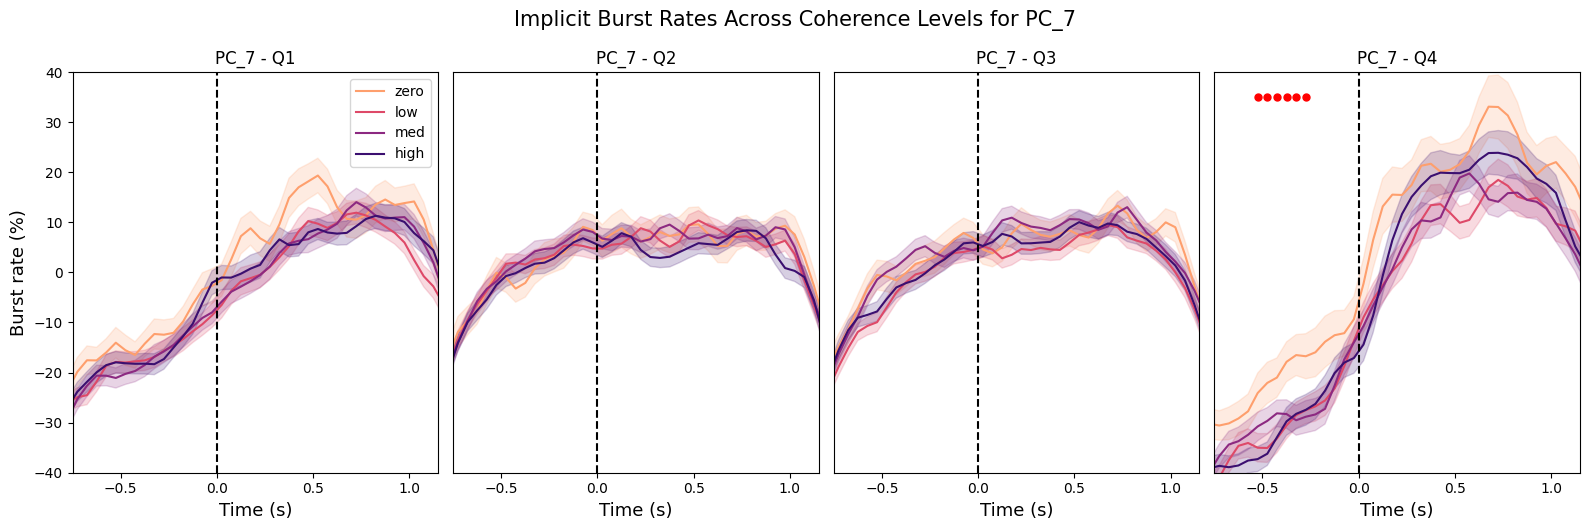

In [19]:
# Define colors for coherence categories
colors4 = sns.color_palette("magma_r", n_colors=4)
coh_colors = {
    "zero": colors4[0],
    "low": colors4[1],
    "med": colors4[2],
    "high": colors4[3]
}

# Define time range
plot_time_range = [-0.75, 1.15]

# Define PC and coherence categories
selected_PCs = ['PC_7']  # Only PC_7
coh_cats = ['zero', 'low', 'med', 'high']

# Create figure (1 row = PC_7, 4 columns = quartiles)
fig, axs = plt.subplots(1, 4, figsize=(16, 5), sharey=True)

pc = 'PC_7'  # Single PC
implicit_data_all_coh = {
    coh: globals().get(f"group_implicit_{pc}_{coh}", {}) for coh in coh_cats
}

for i in range(4):  # Loop through quartiles
    ax = axs[i]

    # Extract quartile data for each coherence level
    coh_burst_rates = {}
    for coh in coh_cats:
        keys = [(blk, i) for blk in range(1, 7)]  # Aggregate across blocks
        if any(k in implicit_data_all_coh[coh] for k in keys):
            coh_burst_rates[coh] = np.vstack(
                [implicit_data_all_coh[coh][k] for k in keys if k in implicit_data_all_coh[coh]]
            )

    # Ensure we have data for all coherence categories
    if len(coh_burst_rates) == 4:
        # Compute mean & SEM for each coherence level
        coh_means = {coh: coh_burst_rates[coh].mean(axis=0) for coh in coh_cats}
        coh_sems = {coh: coh_burst_rates[coh].std(axis=0) / np.sqrt(coh_burst_rates[coh].shape[0]) for coh in coh_cats}

        # Plot coherence data
        for coh in coh_cats:
            ax.plot(mot_time_range, coh_means[coh], label=coh, color=coh_colors[coh])
            ax.fill_between(mot_time_range, coh_means[coh] - coh_sems[coh], coh_means[coh] + coh_sems[coh], alpha=0.2, color=coh_colors[coh])

        # Set axis limits and labels
        ax.set_xlim(plot_time_range)
        ax.axvline(x=0, color='black', linestyle='--')

        if i == 0:
            ax.set_ylabel('Burst rate (%)', fontsize=13)
            ax.yaxis.set_visible(True)  # Ensure y-axis is visible
        else:
            ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

        ax.set_xlabel('Time (s)', fontsize=13)
        ax.xaxis.set_major_locator(plt.MaxNLocator(4))

        ax.set_title(f'{pc} - Q{i+1}')
        ax.set_ylim(-40, 40)

        # Statistical testing: Compare coherence categories within quartiles
        selected_time_indices = (mot_time_range >= plot_time_range[0]) & (mot_time_range <= plot_time_range[1])
        selected_time_points = mot_time_range[selected_time_indices]

        t_obs, clusters, p_values, _ = permutation_cluster_test(
            [coh_burst_rates[coh][:, selected_time_indices] for coh in coh_cats],
            n_permutations=10000, n_jobs=1
        )

        # If significant clusters exist
        if p_values.size > 0:
            print(f'Minimum p-value for {pc} - Q{i+1}:', p_values.min())
            concatenated_sig_mask = np.zeros(len(selected_time_points), dtype=bool)

            for cluster, p_val in zip(clusters, p_values):
                if p_val < 0.05:
                    cluster_indices = cluster[0]
                    concatenated_sig_mask[cluster_indices] = True
                    ax.scatter(selected_time_points[concatenated_sig_mask], 
                               [35] * sum(concatenated_sig_mask), 
                               color='red', s=25)
        else:
            print(f'No significant clusters found for {pc} - Q{i+1}.')

    # Only add legend to the first subplot
    if i == 0:
        ax.legend()
    else:
        ax.legend().set_visible(False)

# Adjust layout and display the plots
plt.tight_layout()
plt.suptitle('Implicit Burst Rates Across Coherence Levels for PC_7', fontsize=15, y=1.05)
plt.show()


Using a threshold of 2.625748
stat_fun(H1): min=0.629929 max=4.847598
Running initial clustering …
Found 8 clusters


C:\Users\qmoreau\AppData\Local\Temp\ipykernel_28336\694072817.py:68: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  t_obs, clusters, p_values, _ = permutation_cluster_test(


  0%|          | Permuting : 0/9999 [00:00<?,       ?it/s]

Minimum p-value for PC_7 - Q1: 0.0952
Using a threshold of 2.625748
stat_fun(H1): min=0.265905 max=2.109913
Running initial clustering …
Found 0 clusters
No significant clusters found for PC_7 - Q2.
Using a threshold of 2.625748
stat_fun(H1): min=0.019787 max=1.878886
Running initial clustering …
Found 0 clusters
No significant clusters found for PC_7 - Q3.
Using a threshold of 2.625748
stat_fun(H1): min=0.096859 max=5.559130
Running initial clustering …
Found 2 clusters


C:\Users\qmoreau\AppData\Local\Temp\ipykernel_28336\694072817.py:68: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  t_obs, clusters, p_values, _ = permutation_cluster_test(
C:\Users\qmoreau\AppData\Local\Temp\ipykernel_28336\694072817.py:68: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  t_obs, clusters, p_values, _ = permutation_cluster_test(
C:\Users\qmoreau\AppData\Local\Temp\ipykernel_28336\694072817.py:68: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  t_obs, clusters, p_values, _ = permutation_cluster_test(
C:\Users\qmoreau\AppData\Local\Temp\ipykernel_28336\694072817.py:68: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  t_obs, clusters, p_values, _ = permutation_cluster_test(
C:\Users\qmoreau\AppData\Local\Temp\ipykernel_28336\694072817.py:68: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  t_obs, clusters, p_values, _ = permutation_cluster

  0%|          | Permuting : 0/9999 [00:00<?,       ?it/s]

Minimum p-value for PC_7 - Q4: 0.0491


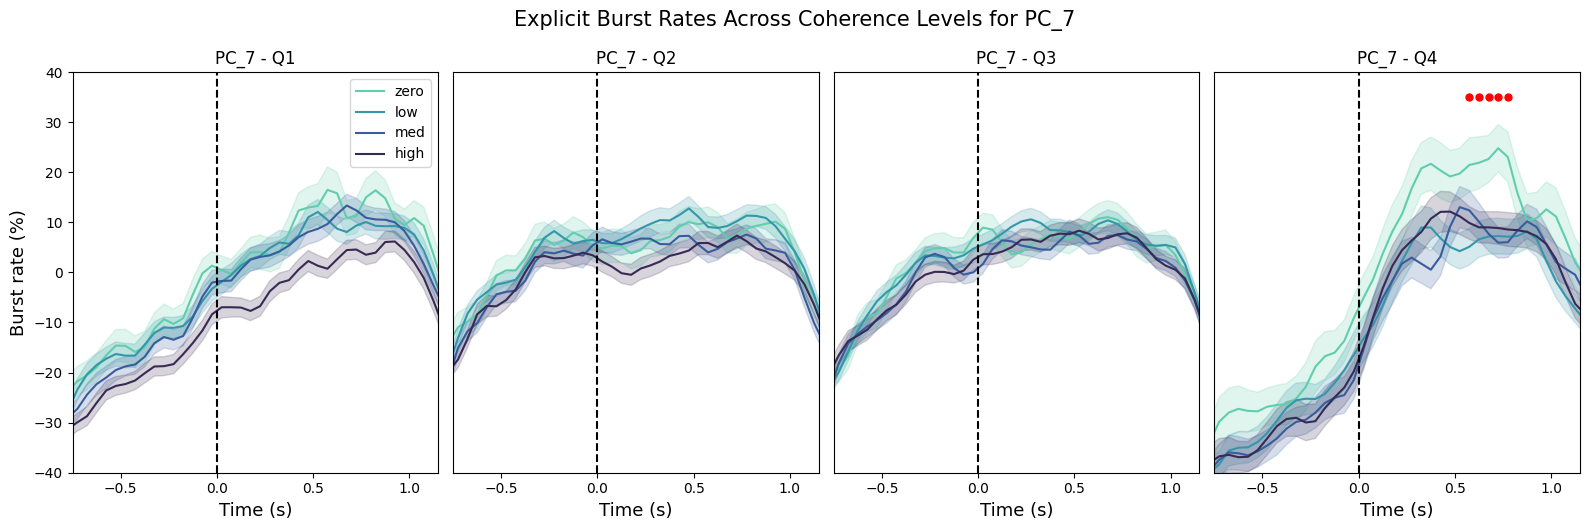

In [20]:

# Define colors for coherence categories
colors4 = sns.color_palette("mako_r", n_colors=4)
coh_colors = {
    "zero": colors4[0],
    "low": colors4[1],
    "med": colors4[2],
    "high": colors4[3]
}

# Define time range
plot_time_range = [-0.75, 1.15]

# Define PC and coherence categories
selected_PCs = ['PC_7']  # Only PC_7
coh_cats = ['zero', 'low', 'med', 'high']

# Create figure (1 row = PC_7, 4 columns = quartiles)
fig, axs = plt.subplots(1, 4, figsize=(16, 5), sharey=True)

pc = 'PC_7'  # Single PC
explicit_data_all_coh = {
    coh: globals().get(f"group_explicit_{pc}_{coh}", {}) for coh in coh_cats
}

for i in range(4):  # Loop through quartiles
    ax = axs[i]

    # Extract quartile data for each coherence level
    coh_burst_rates = {}
    for coh in coh_cats:
        keys = [(blk, i) for blk in range(1, 7)]  # Aggregate across blocks
        if any(k in explicit_data_all_coh[coh] for k in keys):
            coh_burst_rates[coh] = np.vstack(
                [explicit_data_all_coh[coh][k] for k in keys if k in explicit_data_all_coh[coh]]
            )

    # Ensure we have data for all coherence categories
    if len(coh_burst_rates) == 4:
        # Compute mean & SEM for each coherence level
        coh_means = {coh: coh_burst_rates[coh].mean(axis=0) for coh in coh_cats}
        coh_sems = {coh: coh_burst_rates[coh].std(axis=0) / np.sqrt(coh_burst_rates[coh].shape[0]) for coh in coh_cats}

        # Plot coherence data
        for coh in coh_cats:
            ax.plot(mot_time_range, coh_means[coh], label=coh, color=coh_colors[coh])
            ax.fill_between(mot_time_range, coh_means[coh] - coh_sems[coh], coh_means[coh] + coh_sems[coh], alpha=0.2, color=coh_colors[coh])

        # Set axis limits and labels
        ax.set_xlim(plot_time_range)
        ax.axvline(x=0, color='black', linestyle='--')

        if i == 0:
            ax.set_ylabel('Burst rate (%)', fontsize=13)
            ax.yaxis.set_visible(True)  # Ensure y-axis is visible
        else:
            ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

        ax.set_xlabel('Time (s)', fontsize=13)
        ax.xaxis.set_major_locator(plt.MaxNLocator(4))

        ax.set_title(f'{pc} - Q{i+1}')
        ax.set_ylim(-40, 40)

        # Statistical testing: Compare coherence categories within quartiles
        selected_time_indices = (mot_time_range >= plot_time_range[0]) & (mot_time_range <= plot_time_range[1])
        selected_time_points = mot_time_range[selected_time_indices]

        t_obs, clusters, p_values, _ = permutation_cluster_test(
            [coh_burst_rates[coh][:, selected_time_indices] for coh in coh_cats],
            n_permutations=10000, n_jobs=1
        )

        # If significant clusters exist
        if p_values.size > 0:
            print(f'Minimum p-value for {pc} - Q{i+1}:', p_values.min())
            concatenated_sig_mask = np.zeros(len(selected_time_points), dtype=bool)

            for cluster, p_val in zip(clusters, p_values):
                if p_val < 0.05:
                    cluster_indices = cluster[0]
                    concatenated_sig_mask[cluster_indices] = True
                    ax.scatter(selected_time_points[concatenated_sig_mask], 
                               [35] * sum(concatenated_sig_mask), 
                               color='red', s=25)
        else:
            print(f'No significant clusters found for {pc} - Q{i+1}.')

    # Only add legend to the first subplot
    if i == 0:
        ax.legend()
    else:
        ax.legend().set_visible(False)

# Adjust layout and display the plots
plt.tight_layout()
plt.suptitle('Explicit Burst Rates Across Coherence Levels for PC_7', fontsize=15, y=1.05)
plt.show()


Quartile 1: No significant time points after FDR correction
Quartile 2: 28 significant time points after FDR correction
  Significant segment: -0.225s to 1.125s (duration: 1.350s), min p = 0.000040
Quartile 3: No significant time points after FDR correction
Quartile 4: 20 significant time points after FDR correction
  Significant segment: -0.025s to 0.925s (duration: 0.950s), min p = 0.000324


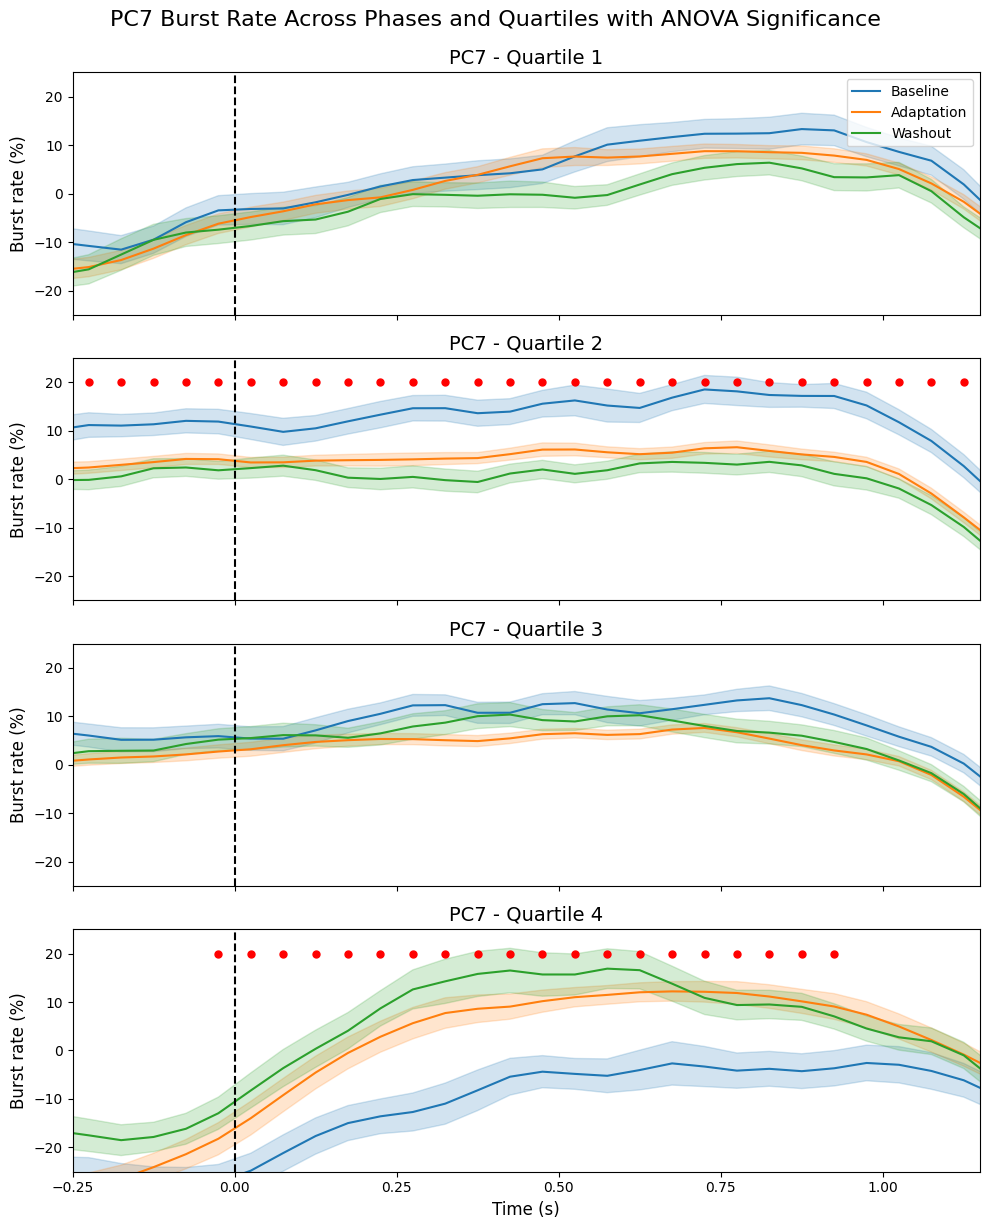


Summary of One-way ANOVA Results for PC7 Across Quartiles:
Quartile   Min p-value     Time (s)        Sig. after FDR      
----------------------------------------------------------------------
Q1         0.014531        0.575           No                  
Q2         0.000002        0.925           Yes                 
Q3         0.003633        1.125           No                  
Q4         0.000022        0.575           Yes                 


In [27]:
from scipy.stats import f_oneway
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import fdrcorrection as fdr_correction
import scipy.stats as stats

# Set the common time range
plot_time_range = [-0.25, 1.15]

# Create a figure with 4 subplots (one for each quartile)
fig, axs = plt.subplots(4, 1, figsize=(10, 12), sharex=True)

# Define colors for the three phases
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Blue, Orange, Green
phase_labels = ['Baseline', 'Adaptation', 'Washout']

# Create a list of the phase dictionaries
phase_dicts = [mot_burst_rates_dict_PC_7_baseline, mot_burst_rates_dict_PC_7, mot_burst_rates_dict_PC_7_washout]

# Loop through each quartile
for i in range(4):
    # Loop through each phase
    for j, (phase_dict, phase_label, color) in enumerate(zip(phase_dicts, phase_labels, colors)):
        # Get quartile keys for both groups
        key_group_0 = f"group_0_mot_burst_rates_Q{i}"
        key_group_1 = f"group_1_mot_burst_rates_Q{i}"
        
        # Combine data from both groups for this phase
        combined_data = np.vstack((phase_dict[key_group_0], phase_dict[key_group_1]))
        
        # Plot the mean across all subjects
        line, = axs[i].plot(mot_time_range, combined_data.mean(axis=0), label=phase_label, color=color)
        
        # Add shaded error region (standard error)
        axs[i].fill_between(
            mot_time_range,
            combined_data.mean(axis=0) - combined_data.std(axis=0) / np.sqrt(len(combined_data)),
            combined_data.mean(axis=0) + combined_data.std(axis=0) / np.sqrt(len(combined_data)), 
            alpha=0.2, 
            color=color
        )
    
    # Set x-axis limits
    axs[i].set_xlim(plot_time_range)
    
    # Add a vertical line at time 0
    axs[i].axvline(x=0, color='black', linestyle='--')
    
    # Set y-label for all subplots
    axs[i].set_ylabel('Burst rate (%)', fontsize=12)
    
    # Set title for each quartile
    axs[i].set_title(f'PC7 - Quartile {i+1}', fontsize=14)
    
    # Set y-axis limits
    axs[i].set_ylim(-25, 25)
    
    # Statistical analysis section
    selected_time_indices = (mot_time_range >= plot_time_range[0]) & (mot_time_range <= plot_time_range[1])
    selected_time_points = mot_time_range[selected_time_indices]
    
    # Prepare data for one-way ANOVA
    baseline_data = np.vstack((
        phase_dicts[0][key_group_0][:, selected_time_indices],
        phase_dicts[0][key_group_1][:, selected_time_indices]
    ))
    
    adaptation_data = np.vstack((
        phase_dicts[1][key_group_0][:, selected_time_indices],
        phase_dicts[1][key_group_1][:, selected_time_indices]
    ))
    
    washout_data = np.vstack((
        phase_dicts[2][key_group_0][:, selected_time_indices],
        phase_dicts[2][key_group_1][:, selected_time_indices]
    ))
    
    # Calculate p-values at each time point using one-way ANOVA
    p_values = np.zeros(len(selected_time_points))
    
    for t in range(len(selected_time_points)):
        # Extract data at this time point
        baseline_t = baseline_data[:, t]
        adaptation_t = adaptation_data[:, t]
        washout_t = washout_data[:, t]
        
        # Run one-way ANOVA
        _, p_val = f_oneway(baseline_t, adaptation_t, washout_t)
        p_values[t] = p_val
    
    # Apply FDR correction to p-values
    _, p_values_fdr = fdr_correction(p_values, alpha=0.05, method='indep')
    
    # Find significant time points
    sig_mask = p_values_fdr < 0.05
    
    # Mark significant time points on the plot
    if np.any(sig_mask):
        # Plot dots for each significant time point
        axs[i].scatter(
            selected_time_points[sig_mask],
            [20] * np.sum(sig_mask),  # Position at top of plot
            color='red',
            s=25,  # Point size
            marker='o'
        )
        
        # Find segments of consecutive significant time points
        sig_indices = np.where(sig_mask)[0]
        
        # Initialize variables for finding consecutive segments
        starts = []
        ends = []
        
        if len(sig_indices) > 0:
            # Start the first segment
            segment_start = sig_indices[0]
            prev_idx = sig_indices[0]
            
            # Loop through the remaining indices
            for idx in sig_indices[1:]:
                # If this index is not consecutive with the previous one
                if idx != prev_idx + 1:
                    # End the previous segment
                    ends.append(prev_idx)
                    # Start a new segment
                    starts.append(idx)
                    segment_start = idx
                prev_idx = idx
            
            # End the last segment
            ends.append(sig_indices[-1])
            
            # Make sure we have the same number of starts and ends
            if len(starts) == 0 and len(ends) == 1:
                # Special case: only one segment that starts at the first significant point
                starts.append(sig_indices[0])
        
        # Print information about significant segments
        print(f"Quartile {i+1}: {np.sum(sig_mask)} significant time points after FDR correction")
        for start, end in zip(starts, ends):
            start_time = selected_time_points[start]
            end_time = selected_time_points[end]
            duration = end_time - start_time
            min_p_in_segment = np.min(p_values_fdr[start:end+1])
            print(f"  Significant segment: {start_time:.3f}s to {end_time:.3f}s (duration: {duration:.3f}s), min p = {min_p_in_segment:.6f}")
    else:
        print(f"Quartile {i+1}: No significant time points after FDR correction")
    
    # Add legend only to the first subplot
    if i == 0:
        axs[i].legend(loc='upper right')

# Add x-label only to the bottom subplot
axs[3].set_xlabel('Time (s)', fontsize=12)

# Set fewer ticks on x-axis for all subplots
for ax in axs:
    ax.xaxis.set_major_locator(plt.MaxNLocator(6))

# Adjust layout to prevent overlap
plt.tight_layout()
plt.suptitle('PC7 Burst Rate Across Phases and Quartiles with ANOVA Significance', fontsize=16, y=1.02)

# Show the plot
plt.show()

# Print a summary table of minimum p-values for each quartile
print("\nSummary of One-way ANOVA Results for PC7 Across Quartiles:")
print("=" * 70)
print(f"{'Quartile':<10} {'Min p-value':<15} {'Time (s)':<15} {'Sig. after FDR':<20}")
print("-" * 70)
for i in range(4):
    # Recalculate or retrieve p-values for each quartile
    key_group_0 = f"group_0_mot_burst_rates_Q{i}"
    key_group_1 = f"group_1_mot_burst_rates_Q{i}"
    
    baseline_data = np.vstack((
        phase_dicts[0][key_group_0][:, selected_time_indices],
        phase_dicts[0][key_group_1][:, selected_time_indices]
    ))
    
    adaptation_data = np.vstack((
        phase_dicts[1][key_group_0][:, selected_time_indices],
        phase_dicts[1][key_group_1][:, selected_time_indices]
    ))
    
    washout_data = np.vstack((
        phase_dicts[2][key_group_0][:, selected_time_indices],
        phase_dicts[2][key_group_1][:, selected_time_indices]
    ))
    
    p_values = np.zeros(len(selected_time_points))
    
    for t in range(len(selected_time_points)):
        _, p_val = stats.f_oneway(baseline_data[:, t], adaptation_data[:, t], washout_data[:, t])
        p_values[t] = p_val
    
    min_p_idx = np.argmin(p_values)
    min_p = p_values[min_p_idx]
    min_p_time = selected_time_points[min_p_idx]
    
    # Apply FDR correction
    _, p_values_fdr = fdr_correction(p_values, alpha=0.05, method='indep')
    sig_after_fdr = "Yes" if np.any(p_values_fdr < 0.05) else "No"
    
    print(f"Q{i+1:<9} {min_p:<15.6f} {min_p_time:<15.3f} {sig_after_fdr:<20}")
print("=" * 70)

In [28]:

# Load data
waveform_array_file = r"C:\Users\qmoreau\Documents\Work\Beta_bursts\Burst_files\all_waveforms.npy"
waveform_array = np.load(waveform_array_file)

burst_feature = pd.read_csv(r"C:\Users\qmoreau\Documents\Work\Beta_bursts\Burst_files\burst_features.csv\burst_features.csv")


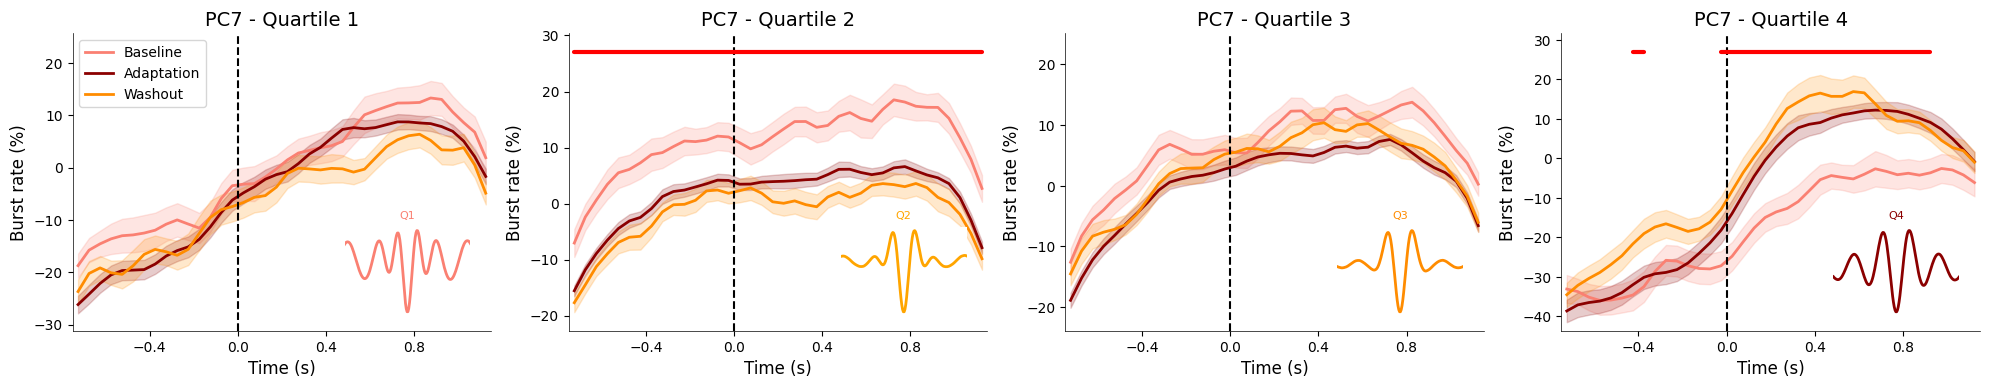


Summary of One-way ANOVA Results for PC7 Across Quartiles:
Quartile   Min p-value     Time (s)        Sig. after FDR      
----------------------------------------------------------------------
Q1         0.014531        0.575           No                  
Q2         0.000002        0.925           Yes                 
Q3         0.003633        1.125           No                  
Q4         0.000022        0.575           Yes                 


In [29]:
from scipy import stats

# Set the common time range
plot_time_range = [-0.75, 1.15]

# Create a figure with subplots in a single row
fig, axs = plt.subplots(1, 4, figsize=(20, 4))
plt.subplots_adjust(wspace=0.3)  # Add some space between plots

# Define colors for the three phases - same for all quartiles
block_colors = ['salmon', 'darkred', 'darkorange']  # salmon for baseline, darkred for adaptation, darkorange for washout
phase_labels = ['Baseline', 'Adaptation', 'Washout']

# Get characteristic colors from different colormaps for each quartile (for waveforms only)
q1_color = 'salmon'      # Quartile 1: cool colormap
q2_color = 'orange'    # Quartile 2: spring colormap
q3_color = 'darkorange'       # Quartile 3: hot colormap
q4_color = 'darkred'   # Quartile 4: viridis colormap

# Combine into an array for easy indexing
quartile_colors = [q1_color, q2_color, q3_color, q4_color]

# Create a list of the phase dictionaries
phase_dicts = [mot_burst_rates_dict_PC_7_baseline, mot_burst_rates_dict_PC_7, mot_burst_rates_dict_PC_7_washout]

# Get indices for the plot time range first (will be used throughout)
selected_time_indices = (mot_time_range >= plot_time_range[0]) & (mot_time_range <= plot_time_range[1])
selected_time_points = mot_time_range[selected_time_indices]

# Create time array for waveform x-axis
waveform_time = np.linspace(-.13, .13, num=156)

# Calculate mean waveform
mean_waveform = np.mean(waveform_array, axis=0)

# Define quartiles (4 equal divisions from 0-100%)
prct = np.linspace(0, 100, num=5)  # [0, 25, 50, 75, 100]
prct_ranges = list(zip(prct[:-1], prct[1:]))  # [(0,25), (25,50), (50,75), (75,100)]

# Create a dictionary to store the waveforms
pc_key = "PC_7"  # We're focusing on PC_7 as requested
wvfrms = []

for low, hi in prct_ranges:
    low_perc = np.percentile(burst_feature[pc_key], low)
    hi_perc = np.percentile(burst_feature[pc_key], hi)
    
    # Get indices of bursts in this quartile, but only from block = 0 (baseline)
    wvf_ixs = burst_feature.loc[
        (burst_feature[pc_key] >= low_perc) & 
        (burst_feature[pc_key] <= hi_perc) & 
        (burst_feature['block'] == 0)
    ].index
    
    # Calculate mean waveform for this quartile
    MWF = np.mean(waveform_array[wvf_ixs, :], axis=0)
    wvfrms.append(MWF)

# Loop through each quartile
for i in range(4):
    # Get the current subplot from the array of axes
    ax_burst = axs[i]
    
    # Remove all spines except the bottom and left
    ax_burst.spines['top'].set_visible(False)
    ax_burst.spines['right'].set_visible(False)
    ax_burst.spines['left'].set_linewidth(0.5)
    ax_burst.spines['bottom'].set_linewidth(0.5)
    
    # Get quartile keys for both groups
    key_group_0 = f"group_0_mot_burst_rates_Q{i}"
    key_group_1 = f"group_1_mot_burst_rates_Q{i}"
    
    # Calculate data only for the selected time range
    baseline_data = np.vstack((
        phase_dicts[0][key_group_0][:, selected_time_indices],
        phase_dicts[0][key_group_1][:, selected_time_indices]
    ))
    
    adaptation_data = np.vstack((
        phase_dicts[1][key_group_0][:, selected_time_indices],
        phase_dicts[1][key_group_1][:, selected_time_indices]
    ))
    
    washout_data = np.vstack((
        phase_dicts[2][key_group_0][:, selected_time_indices],
        phase_dicts[2][key_group_1][:, selected_time_indices]
    ))
    
    # Loop through each phase for the burst rate plots with consistent colors across quartiles
    for j, (phase_dict, phase_label) in enumerate(zip(phase_dicts, phase_labels)):
        # Combine data from both groups for this phase
        if j == 0:
            combined_data = baseline_data
        elif j == 1:
            combined_data = adaptation_data
        else:
            combined_data = washout_data
        
        # Plot using the specified block colors
        line, = ax_burst.plot(selected_time_points, combined_data.mean(axis=0), 
                             label=phase_label, color=block_colors[j], 
                             linewidth=2)
        
        # Add shaded error region (standard error)
        ax_burst.fill_between(
            selected_time_points,
            combined_data.mean(axis=0) - combined_data.std(axis=0) / np.sqrt(len(combined_data)),
            combined_data.mean(axis=0) + combined_data.std(axis=0) / np.sqrt(len(combined_data)), 
            alpha=0.2, 
            color=block_colors[j]
        )
    
    # Set x-axis limits for burst plot
    ax_burst.set_xlim(plot_time_range)
    
    # Add a vertical line at time 0 for burst plot
    ax_burst.axvline(x=0, color='black', linestyle='--')
    
    # Set title for each quartile with quartile-specific color
    ax_burst.set_title(f'PC7 - Quartile {i+1}', fontsize=14, color="black")
    
    # Set dynamic y-axis limits based on data
    all_phase_means = np.vstack([
        baseline_data.mean(axis=0),
        adaptation_data.mean(axis=0),
        washout_data.mean(axis=0)
    ])
    
    # Get min and max values (with padding)
    y_min = np.min(all_phase_means) - 5
    y_max = np.max(all_phase_means) + 5
    
    # Ensure space for significance markers
    significance_space = (y_max - y_min) * 0.15
    ax_burst.set_ylim(y_min, y_max + significance_space)
    
    # Calculate p-values at each time point using one-way ANOVA
    p_values = np.zeros(len(selected_time_points))
    
    for t in range(len(selected_time_points)):
        # Extract data at this time point
        baseline_t = baseline_data[:, t]
        adaptation_t = adaptation_data[:, t]
        washout_t = washout_data[:, t]
        
        # Run one-way ANOVA
        _, p_val = stats.f_oneway(baseline_t, adaptation_t, washout_t)
        p_values[t] = p_val
    
    # Apply FDR correction to p-values
    _, p_values_fdr = fdr_correction(p_values, alpha=0.05, method='indep')
    
    # Find significant time points
    sig_mask = p_values_fdr < 0.05
    
    # Mark significant time points on the plot with a continuous line
    if np.any(sig_mask):
        # Create a continuous significance line at the top of the plot
        # First, find continuous segments of significance
        sig_indices = np.where(sig_mask)[0]
        
        # Break into continuous segments
        breaks = np.where(np.diff(sig_indices) > 1)[0]
        segments = np.split(sig_indices, breaks + 1)
        
        # Draw a line for each continuous segment
        for segment in segments:
            if len(segment) > 0:
                ax_burst.plot(
                    selected_time_points[segment],
                    [y_max + significance_space * 0.5] * len(segment),
                    color='red',
                    linewidth=3,
                    solid_capstyle='round'  # Round line caps
                )
    
    # Create custom legend only for the first subplot (i=0)
    if i == 0:  # Only for the first quartile
        legend_elements = [
            plt.Line2D([0], [0], color=block_colors[0], lw=2, label=phase_labels[0]),
            plt.Line2D([0], [0], color=block_colors[1], lw=2, label=phase_labels[1]),
            plt.Line2D([0], [0], color=block_colors[2], lw=2, label=phase_labels[2])
        ]
        ax_burst.legend(handles=legend_elements, loc='upper left')
    
    # Add y-labels to all burst plots
    ax_burst.set_ylabel('Burst rate (%)', fontsize=12)
    
    # Add x-axis labels to all plots since they're all in one row
    ax_burst.set_xlabel('Time (s)', fontsize=12)
    
    # Set fewer ticks on x-axis
    ax_burst.xaxis.set_major_locator(plt.MaxNLocator(6))

    # Create an inset axes for the waveform inside the burst rate plot
    # Position the inset in the bottom right corner
    ax_wave = ax_burst.inset_axes([0.65, 0.05, 0.3, 0.3])  # [x, y, width, height] as fraction of the main axes
    
    # Plot the waveform using the quartile-specific color
    ax_wave.plot(waveform_time, wvfrms[i] * 1e14, color=quartile_colors[i], linewidth=2)
    
    # Add a small title to the inset
    ax_wave.set_title(f'Q{i+1}', fontsize=8, color=quartile_colors[i])
    
    # Remove all axis ticks and labels for a cleaner look
    ax_wave.set_xticks([])
    ax_wave.set_yticks([])
    
    # Remove all spines completely
    for spine in ax_wave.spines.values():
        spine.set_visible(False)
    
    # Set reasonable x-axis limits
    ax_wave.set_xlim(waveform_time[0], waveform_time[-1])

# Adjust layout to prevent overlap
plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Make room for overall title

# Show the plot
plt.show()

# Summary table code can remain unchanged
print("\nSummary of One-way ANOVA Results for PC7 Across Quartiles:")
print("=" * 70)
print(f"{'Quartile':<10} {'Min p-value':<15} {'Time (s)':<15} {'Sig. after FDR':<20}")
print("-" * 70)
for i in range(4):
    # Get quartile keys
    key_group_0 = f"group_0_mot_burst_rates_Q{i}"
    key_group_1 = f"group_1_mot_burst_rates_Q{i}"
    
    # Calculate data only for the selected time range
    baseline_data = np.vstack((
        phase_dicts[0][key_group_0][:, selected_time_indices],
        phase_dicts[0][key_group_1][:, selected_time_indices]
    ))
    
    adaptation_data = np.vstack((
        phase_dicts[1][key_group_0][:, selected_time_indices],
        phase_dicts[1][key_group_1][:, selected_time_indices]
    ))
    
    washout_data = np.vstack((
        phase_dicts[2][key_group_0][:, selected_time_indices],
        phase_dicts[2][key_group_1][:, selected_time_indices]
    ))
    
    p_values = np.zeros(len(selected_time_points))
    
    for t in range(len(selected_time_points)):
        _, p_val = stats.f_oneway(baseline_data[:, t], adaptation_data[:, t], washout_data[:, t])
        p_values[t] = p_val
    
    min_p_idx = np.argmin(p_values)
    min_p = p_values[min_p_idx]
    min_p_time = selected_time_points[min_p_idx]
    
    # Apply FDR correction
    _, p_values_fdr = fdr_correction(p_values, alpha=0.05, method='indep')
    sig_after_fdr = "Yes" if np.any(p_values_fdr < 0.05) else "No"
    
    print(f"Q{i+1:<9} {min_p:<15.6f} {min_p_time:<15.3f} {sig_after_fdr:<20}")
print("=" * 70)